# Linear Regression With Time Series
https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series

#### Objectives:
- engineer features to model the major time series components (trends, seasons, and cycles)
- visualize time seires with many kinds of *time series plots*,
- create forecasting *hybrids* that combine the strengths of complementary models
- adapt machine learning methods to a variety of forecasting tasks

### What is a Time Series? 

**Time Series**: a set of observations recorded over time. In forecasting applications, the observations are typically recorded with a regular frequency - daily or monthly

In [1]:
import pandas as pd

df = pd.read_csv("./input/ts-course-data/book_sales.csv", 
                 index_col = 'Date', 
                 parse_dates = ['Date'],
).drop('Paperback', axis=1)

df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


The series records the number of hardcover book sales at a retail store over 30 days. 

### Linear Regression with Time Series

The **linear regression** algorithm learns how to make a weighted sum from its input features. For two features:
`target = weight_1 * feature_1 + weight_2 * feature_2 + bias`

During training, the regression algorithm learns values for the parameters `weight_1`, `weight_2`, and `bias` that best fit the `target`. The algorithm is often called *ordinary least squares*. The weights are also called *regression coefficients* and the `bias` is also called the *intercept* because its where it crosses the graph.

#### Time-step features

Two kinds of features unique to time series:
- time-step features
- lag features

**Time-step features* are features that can be derived directly from the time index. Most basic is **time dummy**, which counts off time steps in the series from the beginning to end. 


In [2]:
import numpy as np 

df['Time'] = np.arange(len(df.index))

df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


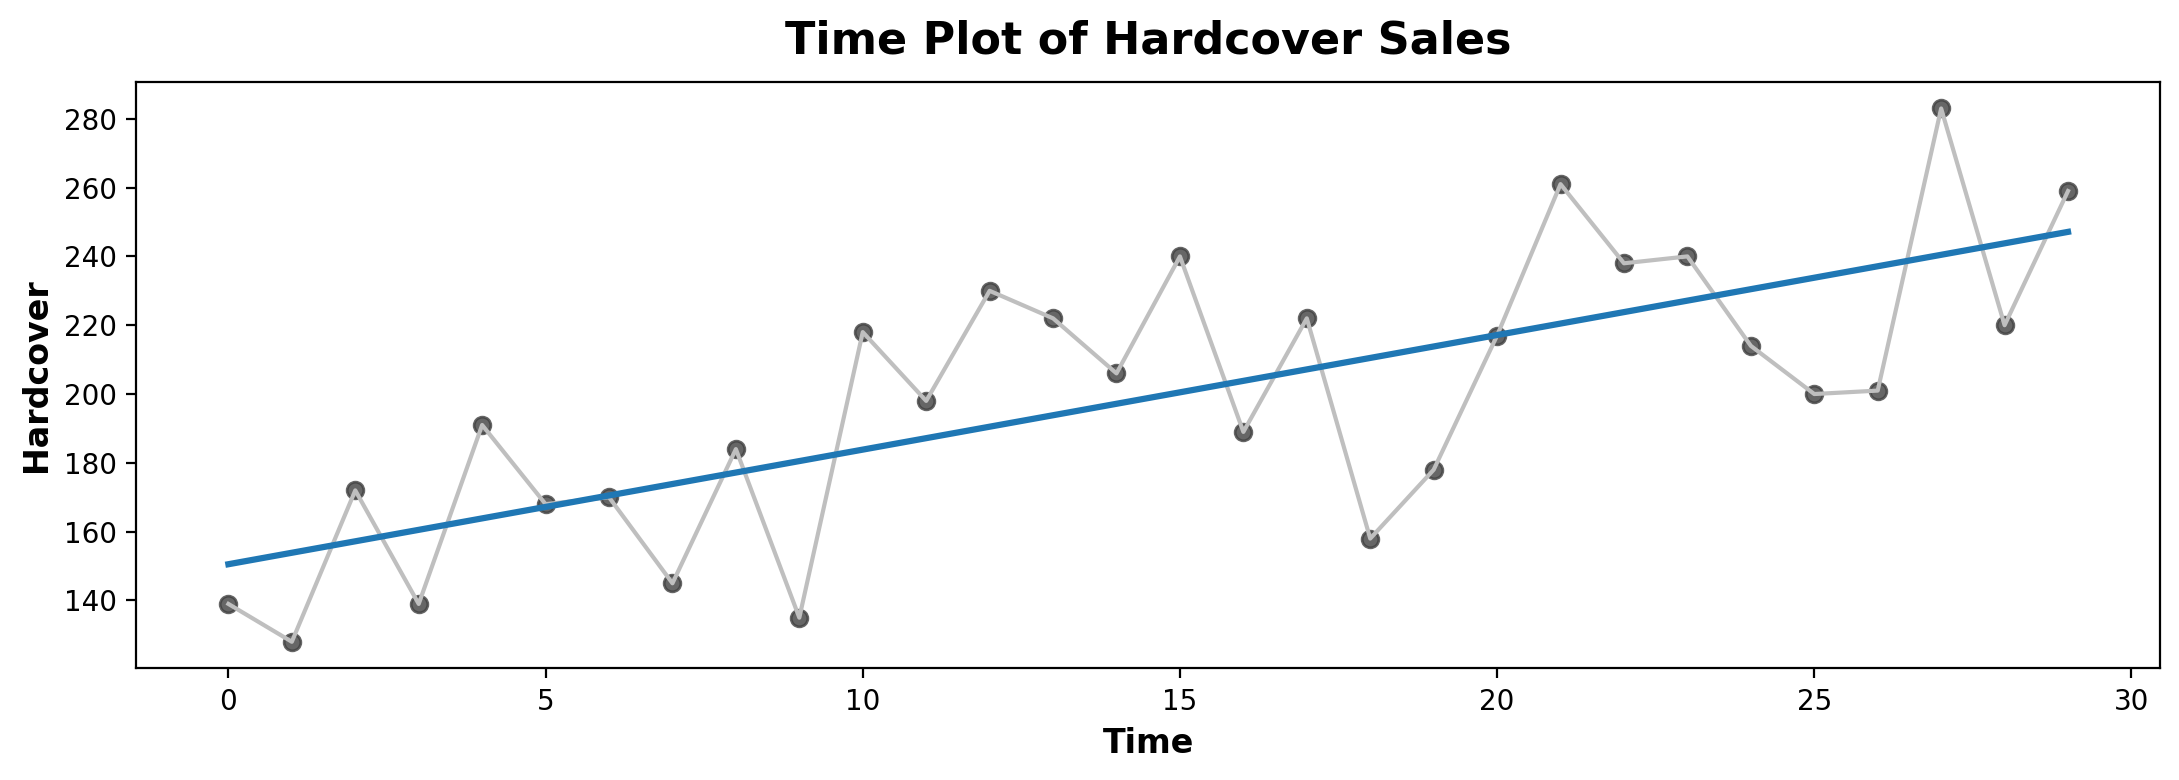

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

**time dependence**: A series is time dependent if its values can be predicted from the time they occured. *Hardcover Sales* series - we can predict that sales later in the month are generally higher than sales earlier in the month

#### Lag features

To make a **lag feature** we shift the observations of the target series so that they appear to have occured later in time. 

In [4]:
df['Lag_1'] = df['Hardcover'].shift(1)
df = df.reindex(columns=['Hardcover', 'Lag_1'])

df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


Linear regression with a lag feature produces:
`target = weigth * lag + bias`
So lag features let us fit curves to *lag plots* where each observation in a series is plotted against the previous observation

Text(0.5, 1.0, 'Lag Plot of Hardcover Sales')

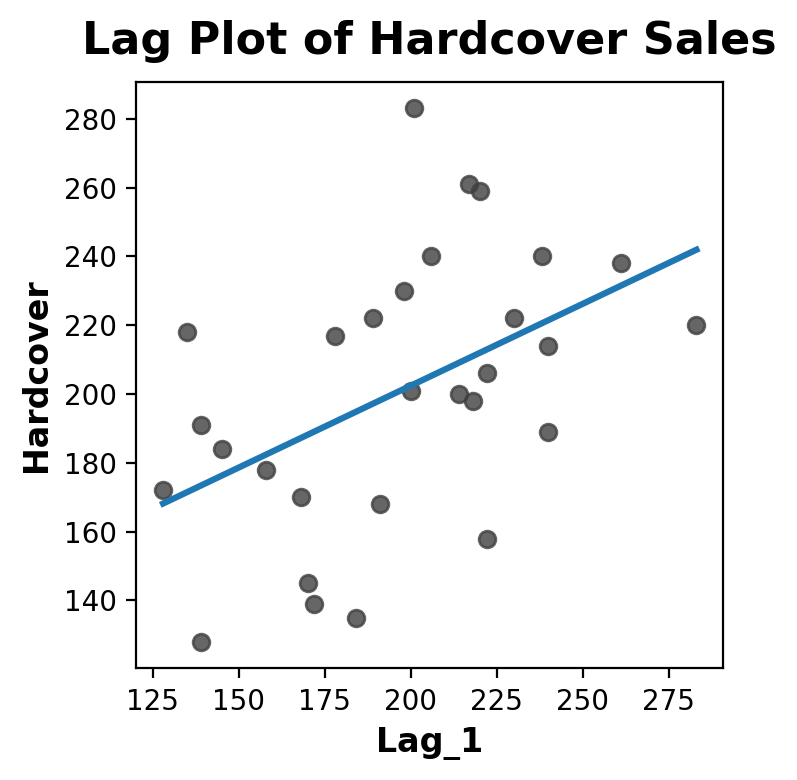

In [20]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales')

Lag features let you model **serial dependence**. A time series has serial dependence when an observation can be predicted from previous observations. 

Adapting machine learning algorithms to time series problems is largely about feature engineering with the time index and lags. For this course, linear regression is used for simplicity, but thease features will be usedful whichever algorithm you choose for your forecasting task. 

### Example - Tunnel Traffic

*Tunnel Traffic* is a time series describing number of vehicles traveling through the Baregg Tunnel in Switzerland each day Nov 2003 - Nov 2005. 

In [22]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

simplefilter("ignore") # ignore warnings to clean up output cells

# Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large", 
    titleweight="bold", 
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25", 
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# Load dataset
data_dir = Path("./input/ts-course-data")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])

# Create time series in Pandas by setting index to a date column
tunnel = tunnel.set_index("Day")

# By default, Pandas creates a DatetimeIndex. 
# A 'PeriodIndex" represents a time series as a sequence of quantities accumulated over periods of time. Periods are often easier to work with. 
tunnel = tunnel.to_period()

tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


### Time-step Feature
Provided the time series doesn't have any missing dates, we can create a time dummy by counting out the length of the series

In [23]:
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


In [24]:
# The procedure for fitting leaner regression omodel follows the standard steps for scikit-learn
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']] # features
y = df.loc[:, 'NumVehicles'] # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fittend values as a tiome series with the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)

The model actually creatd is approximately: `Vehicles = 22.5 * Time + 98176`. Plotting the fitted values over time shows us how fitting linear regression to the time dummy creates the trend line defined by this equation. 

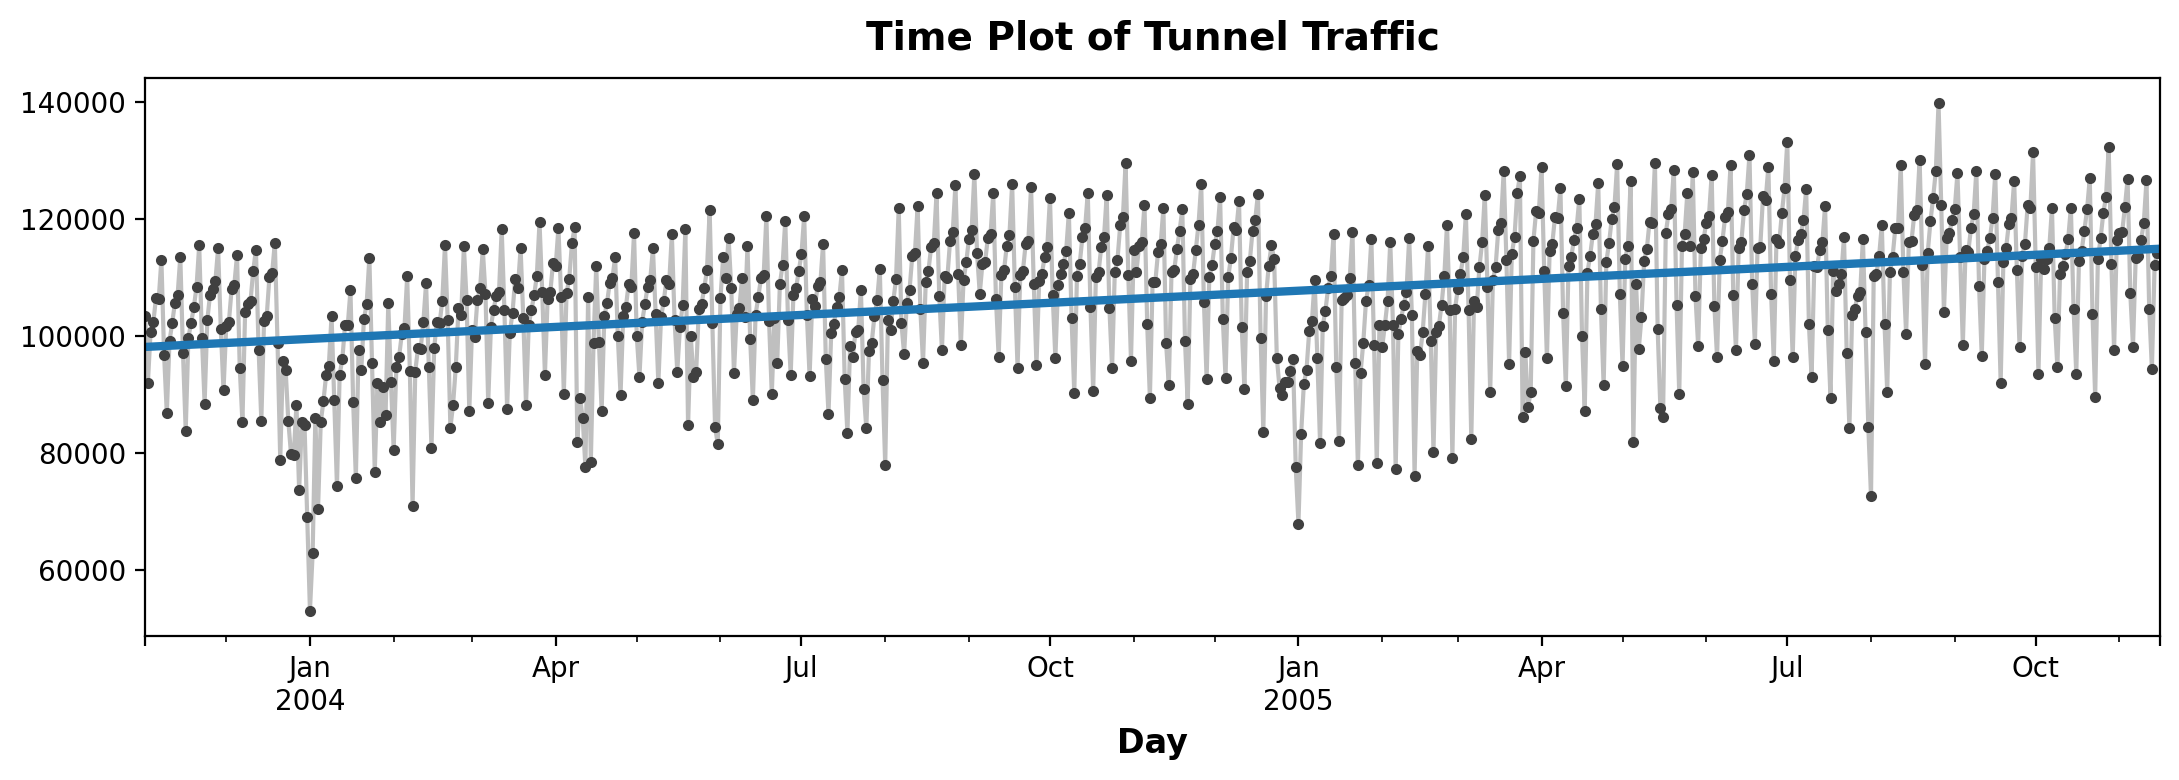

In [26]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

#### Lag Feature

Pandas provides a simple method to lag a series: the `shift` method

In [27]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


When creating lag features, something must be done with the missing values produced. Filling them is one option, with 0.0, or "backfilling" with the first known value. Istead, we'll drop the missing values, making sure to also drop values in the target from corresponding dates. 

In [29]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True) # drop missing values in the feature set
y = df.loc[:, 'NumVehicles'] # create the target
y, X = y.align(X, join='inner') # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

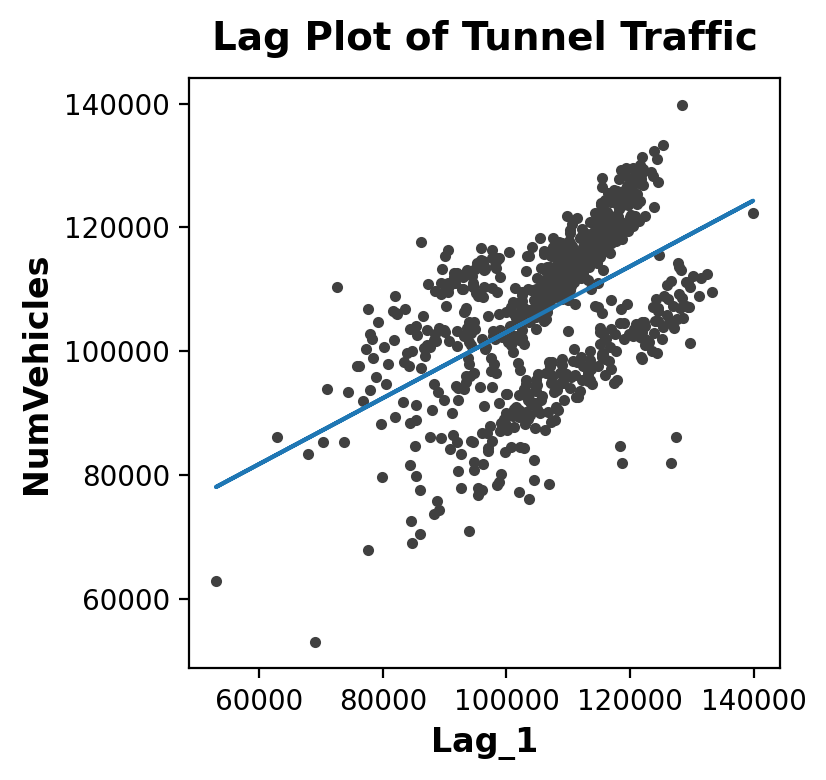

In [30]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

What does this prediction from a lag feature mean about how well we can predict the series across time? The following time plot shows us how our forecasts now respond to the behavior of the series in the recent past: 

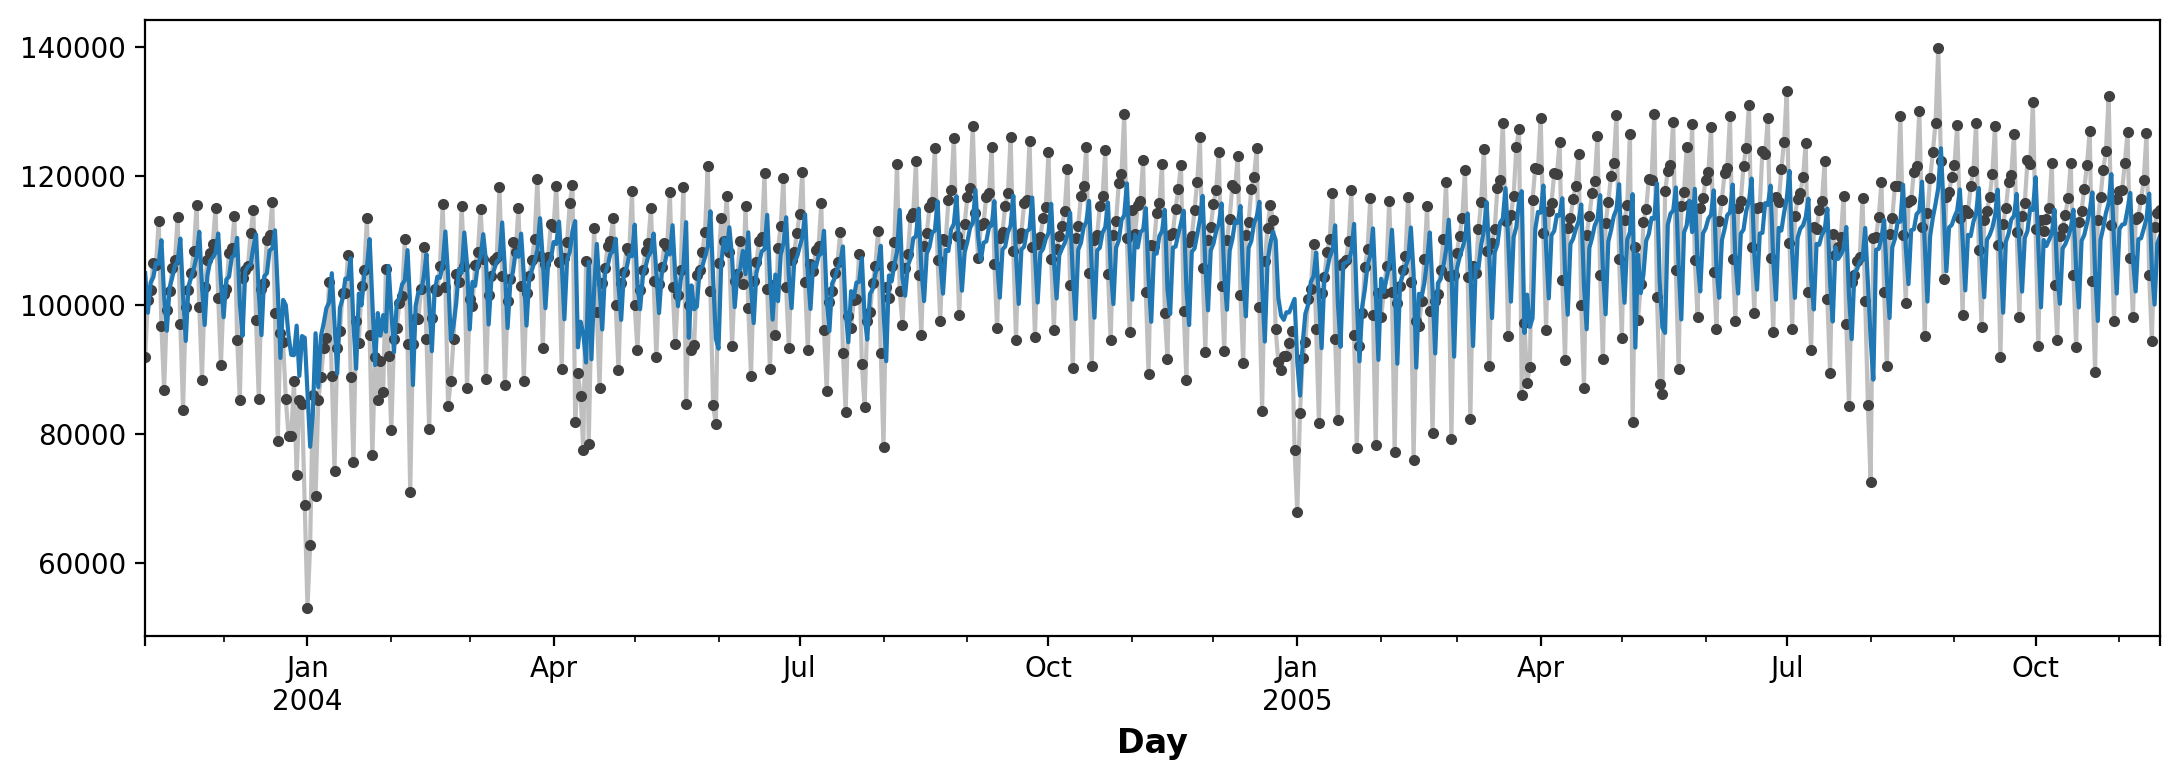

In [31]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

The best time series models will usually included time-step features and lag features. 